# A/B TESTING

## CASE STUDY 2 


**CONTENTS**

- [1. Introduction](#intro)
- [2. Exploratory Data Analysis](#eda)
- [3. Probability](#probability)
- [4. A/B Test](#ab_test)
    - [4.1. A/B Test - Sampling Distribution](#ab_test_sampling)
    - [4.2. A/B Test - Built-in Proportion Z-test](#ab_test_ztest)
    - [4.3. A/B Test - Manual Calculation](#ab_test_manual)
    - [4.4. A/B Test - Logistic Regression Approach](#regression)

<a id='intro'></a>
## 1. INTRODUCTION

### Case study: 

- The `ab_data.csv` data contain the results of an A/B test run by an e-commerce website. We need to check that based on the data, whether the company should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='eda'></a>
## 2. EXPLORATORY DATA ANALYSIS

### 2.1. OVERVIEW ABOUT THE DATA

In [7]:
### Import neccessary packages
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Load the data
data_df = pd.read_csv('data/ab_data.csv')
print(data_df.shape)
data_df.head(3)

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [168]:
print(min(data_df.timestamp), max(data_df.timestamp))

2017-01-02 13:42:05.378582 2017-01-24 13:41:54.460509


In [3]:
data_df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


#### Missing values - Unique - Duplicate

In [58]:
data_df.isnull().sum()
# => There is no missing value

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
### Number of unique user
data_df['user_id'].nunique()

290584

In [64]:
### Duplicate in user_id
data_df.user_id.value_counts()

637561    2
821876    2
643869    2
938802    2
916765    2
         ..
710897    1
708848    1
665839    1
663790    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [62]:
### Number of users that are duplicated 
sum(data_df.user_id.value_counts().values > 1)

3894

#### Check Class Balance (number of observations in each treatment group)

In [8]:
### Ratio between treatment and control
data_df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [9]:
### Ratio of converted
data_df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

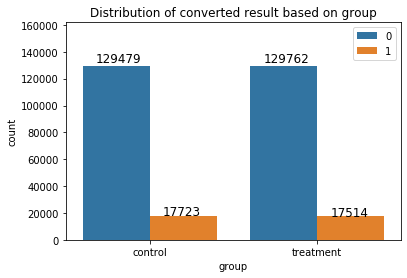

In [56]:
#### Plot the distribution

fig = sns.countplot(data = data_df, x = 'group', hue = 'converted')
### Adding label:
for p in fig.patches:
    if str(p.get_height()) != 'nan':
        fig.text(p.get_x() + 0.08,  
                 p.get_height() * 1.02, 
                 '{}'.format(p.get_height()),
                size = 'large')
plt.legend(loc = 'upper right')
plt.ylim([0, data_df.query('group == "control"').shape[0]*1.1])
plt.title('Distribution of converted result based on group')
plt.show()

### 2.2. SANITY CHECK

PROBLEMS:
1. Control is the old page. Treatment is the new page. But there are some wrong assignments that should be removed.
2. The number of unique user is smaller than the rows => duplicated users => remove

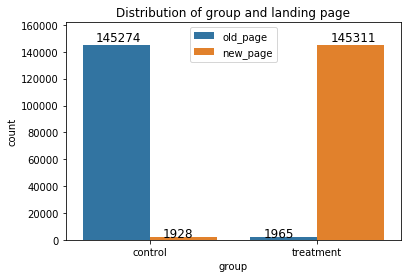

In [57]:
fig = sns.countplot(data = data_df, x = 'group', hue = 'landing_page')
### Adding label:
for p in fig.patches:
    if str(p.get_height()) != 'nan':
        fig.text(p.get_x() + 0.08,  
                 p.get_height() * 1.02, 
                 '{}'.format(p.get_height()),
                size = 'large')
        
plt.legend(loc = 'upper center')
plt.title('Distribution of group and landing page')
plt.ylim([0, data_df.query('group == "control"').shape[0]*1.1])

plt.show()

####  CLEAN UP THE DATA

In [137]:
### Remove the row where group and landing page don't match
df_clean = data_df.query('(group == "treatment" & landing_page != "old_page") | \
              (group == "control" & landing_page != "new_page") ')
df_clean.shape

(290585, 5)

In [138]:
##### The removal above help remove most of the redundant user. 
df_clean.user_id.nunique()

290584

In [139]:
#### Find out about the redundant user
df_clean.user_id.value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [140]:
df_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [141]:
#### User_id the same, just different in timestamp => could use, remove 1 line
df_clean = df_clean.drop(2893)
# Verify the drop
df_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


**TIME OBSERVATION**
- Look good. Only the first day and last day have half number of sample because the feature was launched only half day.

In [169]:
print("Start day: ", min(data_df.timestamp))
print("End day: ", max(data_df.timestamp))

Start day:  2017-01-02 13:42:05.378582
End day:  2017-01-24 13:41:54.460509


In [190]:
df_clean['date'] = pd.to_datetime(df_clean['timestamp']).dt.date
df_clean = df_clean.sort_values(by ='date')
df_clean.head(3)

,user_id,timestamp,group,landing_page,converted,date
184831,929659,2017-01-02 14:41:58.848698,treatment,new_page,0,2017-01-02
148281,779581,2017-01-02 16:31:51.186604,control,old_page,0,2017-01-02
248721,740003,2017-01-02 17:11:05.168172,control,old_page,1,2017-01-02


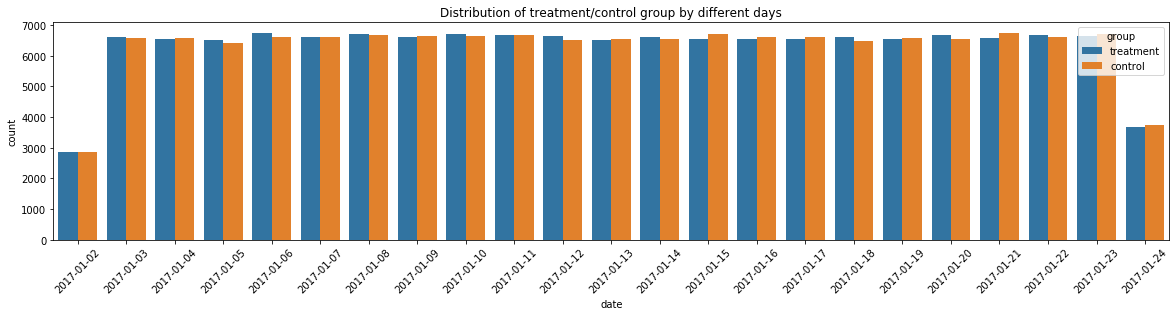

In [192]:
plt.figure(figsize = (20,4))
sns.countplot(data = df_clean, x = 'date', hue = 'group')
plt.xticks(rotation = 45)
plt.title('Distribution of treatment/control group by different days')
plt.show()

<a id='probability'></a>
## 3. PROBABILITY

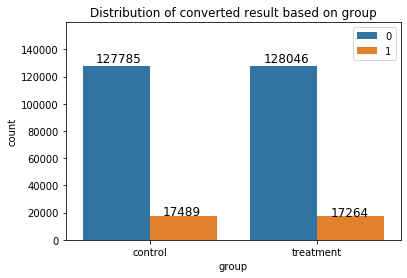

In [91]:
#### Plot the distribution again on the clean dataframe

fig = sns.countplot(data = df_clean, x = 'group', hue = 'converted')
### Adding label:
for p in fig.patches:
    if str(p.get_height()) != 'nan':
        fig.text(p.get_x() + 0.08,  
                 p.get_height() * 1.02, 
                 '{}'.format(p.get_height()),
                size = 'large')
plt.legend(loc = 'upper right')
plt.ylim([0, df_clean.query('group == "control"').shape[0]*1.1])
plt.title('Distribution of converted result based on group')
plt.show()

### Converted ratio

In [92]:
#### Overall converted_ratio
converted_ratio = df_clean.query('converted == 1').user_id.nunique()/df_clean.user_id.nunique()
converted_ratio

0.11959708724499628

In [93]:
# Converted_ratio on the control group
converted_ratio_control = df_clean.query('converted == 1 & group == "control"').user_id.nunique()\
                            /df_clean.query('group == "control"').user_id.nunique()
converted_ratio_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [94]:
# Converted_ratio on the treament group
converted_ratio_treatment = df_clean.query('converted == 1 & group == "treatment"').user_id.nunique()\
                            /df_clean.query('group == "treatment"').user_id.nunique()
converted_ratio_treatment

0.11880806551510564

#### The probability that an individual received the new page

In [95]:
newpage_prob = df_clean.query('landing_page == "new_page"').user_id.nunique()\
                /df_clean.user_id.nunique()
newpage_prob

0.5000619442226688

**The results we have so far:**

- Probability of converting regardless of page: 0.1196.

- The probability student converted in

    + Control group (old page): 0.1204
    + Treatment group (new page): 0.1188

**- These 2 numbers are quite equal. Regarding the fact that the proportion of student received the new page versus the old page are approximately the same (50%), there is unsufficient evidence to conclude that the new treatment page leads to more conversions.**

**=> We need hypothesis testing as evidence to conclude whether the new treatment page leads to more conversions or not**

<a id='ab_test'></a>
## 4. A/B TEST

- Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.
- Metrics: **$p_{old}$** and **$p_{new}$** (the converted rates for the old and new pages).

**The hypothesis:**

$$H_0: p_{new}<= p_{old}$$

$$H_1: p_{new} > p_{old}$$

<a id='ab_test_sampling'></a>
### 4.1. A/B TEST - SAMPLING DISTRIBUTION

**EXPLANATION ABOUT THE APPROACH**

- Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal and equal to the overall converted rate.
- Use a sample size for each page equal to the ones in **ab_data.csv**.
- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

**STEP 1**: Assume under the null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate regardless of page - that is  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  are equal and equal to the overall converted rate.

In [97]:
#### Overall converted_ratio
converted_ratio = df_clean.query('converted == 1').user_id.nunique()/df_clean.user_id.nunique()
p_c, p_t = converted_ratio, converted_ratio
p_c, p_t

(0.11959708724499628, 0.11959708724499628)

**STEP 2**: Use a sample size for each page equal to the ones in the dataset ab_data.csv.

In [99]:
#### The number of users in the control group
n_c = df_clean.query('group == "control"').user_id.nunique()

#### The number of users in the treatment group
n_t = df_clean.query('group == "treatment"').user_id.nunique()
n_c, n_t

(145274, 145310)

(Step 3 and 4 is for demo purpose. In real test, can skip Step 3 and 4, go to Step 5 directly)

**STEP 3**: Simulate n_t, n_c with a conversion rate of p_t, p_c under the null.  

In [108]:
### Approach 1:
treatment_converted = np.random.choice(2, size = n_t, p = [1 - p_t, p_t])
control_converted = np.random.choice(2, size = n_c, p = [1 - p_c, p_c])
### Approach 2:
#treatment_converted = np.random.binomial(1, p_t, size = n_t)
#control_converted = np.random.binomial(1, p_c, size = n_c)

**STEP 4**: Calculate the difference of p_t and p_c from the simulated values under the null:

In [110]:
### Since the array of 1,0, calculating the proportion of 1 produce the same result as calculate mean of the array 
#=> using mean()for more convenient

p_different = treatment_converted.mean() - control_converted.mean()
p_different

0.00027998710628940326

**STEP 5**: Create 10,000 p_different values (p_t - p_c) using the same simulation process in STEP 3 and STEP4. Store all 10,000 values **p_diffs**.

In [111]:
p_diffs = []
for _ in range(10000):
    treatment_converted = np.random.choice(2, size = n_t, p = [1 - p_t, p_t])
    control_converted = np.random.choice(2, size = n_c, p = [1 - p_c, p_c])
    p_different = treatment_converted.mean() - control_converted.mean()
    p_diffs.append(p_different)

**STEP 6**: Plot a histogram of the **p_diffs**.

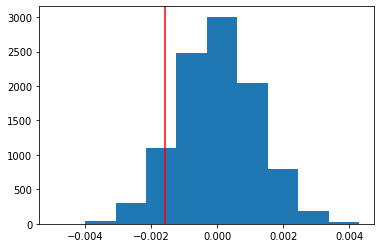

In [113]:
# convert list into numpy array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

## Adding the line of the observed difference from the real ab_dataset
# Converted_ratio on the control group
converted_ratio_control = df_clean.query('converted == 1 & group == "control"').user_id.nunique()\
                            /df_clean.query('group == "control"').user_id.nunique()
# Converted_ratio on the treament group
converted_ratio_treatment = df_clean.query('converted == 1 & group == "treatment"').user_id.nunique()\
                            /df_clean.query('group == "treatment"').user_id.nunique()

plt.axvline(x = converted_ratio_treatment - converted_ratio_control, color = 'red')
plt.show();

**For the test, here is the hypothesis:**

$$H_0: p_{control} ==  p_{treatment} == convertedRatio == 0.11959708724499628$$ 

$$H_1: p_{new} != p_{old}$$

- We simulated the sampling distribution for the treatment and control using a more simple approach: Instead of sampling from the ab_data samples, we generated the new_page_converted and old_page_converted by generating the arrays of random 1 and 0 of size n_new and n_old, respectively, so that the proportion of 1 in the samples was kept as the fix conversion rate under the null hypothesis (converted_ratio == 0.11959708724499628). 
- We then used these sampling distributions to simulate the distribution under the null hypothesis: calculated the differences between the new_page_converted and old_page_converted: **p_diff** = $p_{new}$ - $p_{old}$. 

- Under the null hypothesis, these **p_diffs** should create a random normal distribution centered at 0 with the same spread an size.

**=> According to the histogram, the plot has the normal distribution as we may expect.**

The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**: 

In [90]:
(p_diffs > (converted_ratio_treatment - converted_ratio_control)).mean()

0.90600000000000003

- **After plotting the random normal distribution of p_diffs under the null hypothesis, we computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference in the ab_data.csv** 
- **That p-value is then used to determine the statistical significance of our observed difference**.
- **In this case, p-value = 0.906 > type I error threshold = 0.05 (Type I error rate of 5%) => We fail to reject the null hypothesis**

**=> There is no difference between the new and old pages**


<a id='ab_test_ztest'></a>
### 4.2. A/B TEST - BUILT-IN PROPORTION Z-TEST

**Our hypothesis for the test could be:**

$$H_0: p_{new} <= p_{old}$$

$$H_1: p_{new} > p_{old}$$

**This is the one-tailed test.**


In [116]:
import statsmodels.api as sm

In [117]:
convert_c = df_clean.query('landing_page == "old_page" & converted == 1').shape[0]
convert_t = df_clean.query('landing_page == "new_page" & converted == 1').shape[0]
n_c = df_clean.query('landing_page == "old_page"').shape[0]
n_t = df_clean.query('landing_page == "new_page"').shape[0]
convert_c, convert_t, n_c, n_t

(17489, 17264, 145274, 145310)

In [118]:
count = np.array([convert_t, convert_c])
nobs = np.array([n_t, n_c])
# In the case of a two-sample test, "larger" means that 
# the alternative hypothesis is p_treatment > p_control , which is our case:
stat, pval = sm.stats.proportions_ztest(count, nobs, alternative = "larger")
stat, pval 

(-1.3109241984234394, 0.9050583127590245)

- **The z-score = -1.311 and p-value = 0.905**
- **This z-score indicated that the distance from the new sample mean to the population mean is -1.311 in units of the standard error with the p-value of 0.905**
- **When looking at the z table (for one-tailed ztest):** 

- **The critical Z score values when using a 95% confidence level is +0.9499 standard deviations. The p-value associated with a 95% confidence level is 0.05. If the Z score is +0.9499, your p-value will be larger than 0.05, and you cannot reject your null hypothesis**

- **In this case, z-score = -1.311 (in the left tail of the normal distribution curve) and p-value = 0.905 > 0.05 => We failed to reject the null hypothesis**


**AN EXAMPLE WHEN WE CAN REJECT THE NULL HYPOTHESIS**

In [120]:
### To be clear about interpreting z-score and p-value of the ztest
#### A demo to see when we can reject the null hypothesis:
### when p_new indeed is larger than p_old: 
count = np.array([18000,17489])
nobs = np.array([145310, 145274])
#In the case of a two-sample test, "larger" means that 
#the alternative hypothesis is p_new > p_old , which is our case:
stat, pval = sm.stats.proportions_ztest(count, nobs, alternative = "larger")
stat, pval 
### The result would have z_score is larger than 
# the value 0.95 (in the z-table for 95% confidence level)
# and p_val would be <0.05

(2.870159501258031, 0.0020513239608154444)

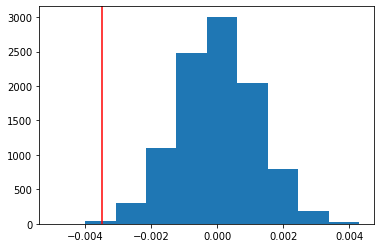

0.9984

In [122]:
# convert list into numpy array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

## Adding the line of the observed difference from the real ab_dataset
# Converted_ratio on the control group
converted_ratio_control = count[0]/nobs[0]
# Converted_ratio on the treament group
converted_ratio_treatment = count[1]/nobs[1]

plt.axvline(x = converted_ratio_treatment - converted_ratio_control, color = 'red')
plt.show();
(p_diffs > (converted_ratio_treatment - converted_ratio_control)).mean()

<a id='ab_test_manual'></a>
### 4.3. A/B TEST - MANUAL CALCULATION

**STEP 1**: Make the conditions for the test

- Practically significant boundary: 1%
- Statistically significant level alpha: 0.05

**STEP 2**: Calculate all the neccessary information.
- The sample size is large enough => Z-test
- Calculate treatment/control converted ratio p_t, p_c
- Calculate center of confident interval d = p_t - p_c
- Calculate the whole population converted ratio p
- Calculate the pooled SE_pool:
    SE_pool = np.sqrt((p * (1-p) * (1/n_c + 1/n_t))
- Calculate test statistic: 
    TS = (p_t - p_c)/SE_pool => checking statistical significance
- Calculate Width of Confident Interval (margin of error)
    m = Z * SE_pool = 1.96 * SE_pool
    => checking pratical significance.

In [153]:
#### Calculate the sample size
convert_c = df_clean.query('landing_page == "old_page" & converted == 1').shape[0]
convert_t = df_clean.query('landing_page == "new_page" & converted == 1').shape[0]
n_c = df_clean.query('landing_page == "old_page"').shape[0]
n_t = df_clean.query('landing_page == "new_page"').shape[0]
convert_c, convert_t, n_c, n_t

(17489, 17264, 145274, 145310)

In [158]:
### Control converted ratio
p_c = convert_c/n_c
p_c

0.1203863045004612

In [157]:
### Treatment converted ratio
p_t = convert_t/n_t
p_t

0.11880806551510564

In [164]:
### Calculate center of confident interval d = p_t - p_c
d = p_t - p_c
d

-0.0015782389853555567

In [160]:
### converted ratio of the whole population
p = (convert_c + convert_t)/(n_c + n_t)
p

0.11959708724499628

In [162]:
### Calculate the pooled SE between 2 groups:
SE_pool = np.sqrt((p*(1-p)*(1/n_c + 1/n_t)))
SE_pool

0.0012039132295014454

In [163]:
### Calculate the test statistic
TS = (p_t - p_c)/SE_pool
TS

-1.3109241984234394

In [165]:
### Width of CI (margin of error)
m = 1.96 * SE_pool
m

0.002359669929822833

In [167]:
m - d

0.00393790891517839

**Check statistical significance:** 

Z-score of alpha = 0.05: 1.96
If TS > 1.96 or TS < -1.96 => reject null hypothesis. 

**In this case, TS = -1.31 => cannot reject the null hypothesis.**

**Check pratical significance:** 

- Center of confident interval d = -0.001578
- CI of d:  -0.001578 +/- 0.00236: 0.00235 ~ 0.00393
=> Not confident the change is pratically significant => not recommend launch the feature.


<a id='regression'></a>
### 4.4. A/B TEST - LOGISTIC REGRESSION APPROACH

**STEP 1**: Create the intercept anhd the dummy variable 

In [142]:
### assign the intercept = 1
df2 = df_clean.copy()
df2['intercept'] = 1

In [144]:
### Create an dummpy variable ab_page: 0 for control, 1 for treatment
df2['ab_page'] = df2.group.apply(lambda x: 1 if x == 'treatment' else 0)

In [145]:
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0


**STEP 2**: Use **statsmodels** to instantiate the regression model on the two columns you created in STEP1, then fit the model to predict whether or not an individual converts. 

In [146]:
### Include these 2 lines to fix the error
# "module 'scipy.stats' has no attribute 'chisqprob'""
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# instantiate your regression model and fit the model 
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**STEP 3**: Interpret the result

In [147]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Nov 2021   Pseudo R-squ.:               8.077e-06
Time:                        19:02:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

- **Null hypothesis of the logistic regression: There is no relationship between the X variable - the page a customer receives and the Y variable (the conversion rates).**
- **The alternative hypothesis: the page a customer receives affects the conversion rates.**

In [101]:
### Interpret Results:
ab_page_coef = -0.0150
1/np.exp(ab_page_coef) #Use 1/np.exp() for negative coef value

1.0151130646157189

- **The result would be understand as for 1 unit decrease in the X variable (shift from 1 to 0 in the dummies variable - the page a customer receives change from new page to old page), the conversion rates will be increase 1 unit.**
- **However, the p-value associated with ab_page is 0.190: The ab_page variable (the page a customer receives) is not statistically significant for predicting the conversion rates. In other words, there is no significant difference in conversion based on which page a customer receives.**

**Since this current variable just show which page the customer views/receives, we cannot gain insights into the reasons that customer want to convert. Including other variables into the model may be good to predict whether the individual converts. Other variables such as:**
- Number of visit the page (views)
- Duration of viewing the page
- The days (weekday, weekend) to visit the page
- The season/holidays that may affect customer interest
- The time of day (morning/afternoon/night)
- The region the customers live in.
- The age range, gender group.

**Disadvantages to adding additional features:**
- There may be variance inflation factors and multicollinearity that may impact the model coefficients.
- Multiple features will make the result interpretation more complicated.